In [1]:
import numpy as np, cython, time
import serial
from ximea import xiapi
import logging
import cv2
logging.basicConfig(level=logging.DEBUG)

In [2]:
class camera():
    def __init__(self,exposure_time:cython.int = int(10000),trigger_source:str='hardware') -> None:
        self.logger = logging.getLogger('camera logs')
        self.trigger_source = trigger_source
        self.exposure_time = exposure_time
        self.open_device()

    def open_device(self):
        self.logger.info(f'trigger sou;rce: {self.trigger_source}')
        self.device:xiapi.Camera = xiapi.Camera()
        self.settings()
        try:
            self.device.close_device()
        except:
            pass
        self.logger.info('device is openning ...')
        self.device.open_device()
        self.logger.info('device is up')
        self.device.stop_acquisition()
        self.apply_settings()
        
        self.img = self.device,xiapi.Image()

    def apply_settings(self):
        # trigger_source
        self.device.set_param( 'trigger_source',self.trigger['source'])
        self.logger.info(f'trigger_source set to: {self.trigger["source"]}')
        # Trigger Selector
        self.device.set_param('trigger_selector',self.trigger['selector'])
        self.logger.info(f'trigger_selector set to: {self.trigger["selector"]}') 
        # GPI Mode
        self.device.set_param( 'gpi_mode',self.gpi['mode'])
        self.logger.info(f'gpi_mode set to: {self.gpi["mode"]}') 
        # GPI Selector
        self.device.set_param( 'gpi_selector',self.gpi['selector'])
        self.logger.info(f'gpi_selector set to: {self.gpi["selector"]}')
        # GPO Mode
        self.device.set_param( 'gpo_mode',self.gpo['mode'])
        self.logger.info(f'gpo_mode set to: {self.gpo["mode"]}') 
        # Auto Exposure
        self.device.set_param('aeag',self.general['auto_exposure'])# or 1 AutoExposure
        self.logger.info(f'Auto exposure set to: {"on" if self.general["auto_exposure"] else "off"}')
        # Exposure Time
        if not self.general['auto_exposure']:
            self.device.set_param('exposure',self.general['exposure_time'])
            self.logger.info(f'exposure_time set to: {self.general["exposure_time"]}')
        else:
            # Maximum limit of gain in AEAG procedure.
            self.device.set_param( 'ag_max_limit',self.general['ag_max_limit'])#db
            self.logger.info(f'ag_max_limit set to: {self.general["ag_max_limit"]}')
            # Maximum limit of exposure (in uSec) in AEAG procedure.
            self.device.set_param( 'ae_max_limit',self.general['ae_max_limit'])#us
            self.logger.info(f'ae_max_limit set to: {self.general["ae_max_limit"]}')
            # Exposure priority for Auto Exposure / Auto Gain function.
            self.device.set_param( 'exp_priority',self.general['exp_priority'])# maximum 1
            self.logger.info(f'exp_priority set to: {self.general["exp_priority"]}')
            # Average intensity of output signal AEAG should achieve(in %).
            self.device.set_param( 'aeag_level',self.general['aeag_level'])
            self.logger.info(f'aeag_level set to: {self.general["aeag_level"]}')
        # Description: Activates Look-Up-Table (LUT).
        # Note1: Possible value: 0 - sensor pixels are transferred directly
        # Note2: Possible value: 1 - sensor pixels are mapped through LUT
        self.device.set_param( 'LUTEnable',self.general['LUTEnable'])
        self.logger.info(f'LUTEnable set to: {self.general["LUTEnable"]}')
        
        #self.device.set_param('acq_frame_burst_count',1)
        #self.device.set_exposure_burst_count(self.general['exposure_burst_count'])


    def settings(self):
        self.trigger = {
                        'source':"XI_TRG_SOFTWARE" if self.trigger_source=='software'\
                                                    else "XI_TRG_EDGE_RISING",
                        'selector':"XI_TRG_SEL_FRAME_START",
                        }
        self.gpi = {'selector':"XI_GPI_PORT1",
                    'mode':"XI_GPI_TRIGGER"
                    }
        
        self.gpo = {'lsector':"XI_GPO_PORT1",
                    'mode':"XI_GPO_BUSY_NEG",
                    'mode_':"XI_GPO_EXPOSURE_ACTIVE_NEG"
                    }
        # ag_max_limit: Maximum limit of gain in AEAG procedure.(db)
        # ae_max_limit: Maximum limit of exposure (in uSec) in AEAG procedure.
        self.general = {'auto_exposure':0,
                        'exposure_time':self.exposure_time,
                        'ag_max_limit':10,
                        'ae_max_limit':10000,
                        'exp_priority':0.5,
                        'aeag_level':50,
                        'LUTEnable':0,
                        'exposure_burst_count':1,
                        }
        
    def get_image(self):
        
        #self.device.start_acquisition()
        # self.device.set_param('trigger_software',1)
        # self.device.get_image(self.img[0])
        # image1:np.ndarray= self.img[0].get_image_data_numpy()
        self.device.get_image(self.img[1])
        image2:np.ndarray= self.img[1].get_image_data_numpy()
        return image2
            

    def close_device(self):
        self.device.stop_acquisition()
        self.device.close_device()

In [3]:
cam = camera() 

INFO:camera logs:trigger sou;rce: hardware
INFO:camera logs:device is openning ...
INFO:camera logs:device is up
INFO:camera logs:trigger_source set to: XI_TRG_EDGE_RISING
INFO:camera logs:trigger_selector set to: XI_TRG_SEL_FRAME_START
INFO:camera logs:gpi_mode set to: XI_GPI_TRIGGER
INFO:camera logs:gpi_selector set to: XI_GPI_PORT1
INFO:camera logs:gpo_mode set to: XI_GPO_BUSY_NEG
INFO:camera logs:Auto exposure set to: off
INFO:camera logs:exposure_time set to: 10000
INFO:camera logs:LUTEnable set to: 0


In [4]:
# Configure the serial port settings
ser = serial.Serial(
    port='/dev/ttyTHS1',   # Replace 'COM1' with the actual serial port name
    baudrate=115200,
    bytesize=serial.EIGHTBITS,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    timeout=0
)


def calculate_checksum(data_bytes):
    # Calculate the XOR checksum of the data bytes
    checksum = 0
    for byte in data_bytes:
        checksum ^= byte
        #print(type(checksum),type(byte))
    return checksum

In [5]:
all_off = [0xaa,0x05,0x00,0x00,0x01,int(hex(14),16),0x01]#,0x00]
all_off.append(calculate_checksum(all_off))
t=time.time()
command_bytes = bytes(all_off)
ser.write(command_bytes)
time.sleep(0.05)
print(time.time()-t)
print(ser.read(8))
print(time.time()-t)


0.060553789138793945
b''
0.062469482421875


In [6]:
def all_off_(cam,ser,trigstate=1):
    # all leds off example (animation is on)
    # protokol= {'command to be sent':0xaa,
    #             'turn all leds off':0x05,
    #             'N/A':0x00,
    #             'N/A':0x00,
    #             'trigger on/off':int(hex(trigstate),16),
    #             'animation speed':int(hex(20),16),
    #             'animation number':0x01,
    #             'checksum':0x00}
    # all_off = list(protokol.values())[:-1]#
    # print(int(hex(trigstate),16))
    try:
        cam.device.start_acquisition()
    except:
        pass
    all_off = [0xaa,0x05,0x00,0x00,0x01,int(hex(14),16),0x00]#,0x00]
    all_off.append(calculate_checksum(all_off))

    command_bytes = bytes(all_off)
    # print('trigstate:',trigstate)
    ser.write(command_bytes)
    
    if trigstate:
        img= cam.get_image()
        cam.device.stop_acquisition()
        return img
    else:
        cam.device.stop_acquisition()
        return 0
        

In [7]:
img= all_off_(cam,ser)

In [8]:
img

array([[19, 18, 21, ...,  8,  8,  9],
       [18, 20, 18, ...,  8,  8,  8],
       [19, 21, 19, ...,  9,  9,  9],
       ...,
       [42, 44, 42, ...,  8,  8,  9],
       [45, 43, 42, ...,  8,  9,  9],
       [46, 45, 44, ...,  8,  8,  9]], dtype=uint8)

In [9]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

In [10]:
all_off = [0xaa,0x05,0x00,0x00,0x00,int(hex(25),16),0x01]#,0x00]
all_off.append(calculate_checksum(all_off))

command_bytes = bytes(all_off)
ser.write(command_bytes)
ser.read(8)

b''

In [11]:
def illuminate(cam,ser):
    # Aydınlatma modu
    protokol= {'command to be sent':0xaa,
                'run auto burst':0x01,
                'N/A':0x00,
                'N/A':0x00,
                'led intensity':int(hex(100),16),
                'animation speed':int(hex(14),16),
                'animation number':0x01,
                'checksum':0x00}

    command = [0xaa,0x01,0x00,0x00,int(hex(100), 16),int(hex(14),16),0x01]
    command.append(calculate_checksum(command))
    command_bytes = bytes(command)
    # print(command_bytes)
    ser.write(command_bytes)   
    # print(ser.read(8))
    return cam.get_image()

In [12]:
command = [0xaa,0x01,0x00,0x00,int(hex(100), 16),int(hex(14),16),0x01]
command.append(calculate_checksum(command))
command_bytes = bytes(command)
print(command_bytes)
ser.write(command_bytes) 

b'\xaa\x01\x00\x00d\x0e\x01\xc0'


8

In [13]:
command = [0xaa,0x01,0x00,0x00,int(hex(100), 16),int(hex(25),16),0x01]
command.append(calculate_checksum(command))
command_bytes = bytes(command)
print(command_bytes)
ser.write(command_bytes) 

b'\xaa\x01\x00\x00d\x19\x01\xd7'


8

In [14]:
def single_trigger(cam,
                    ser,
                    ledNum,
                    TrigDelay=10,
                    LedDelay=0,
                    Parlaklık=100):
    # 0xAA	0x06	0x00	TrigDelay	LedDelay	Parlaklık	IR Led No	Byte1 xor Byte1 xor … xor Byte7
    protokol = {'command to be sent':0xaa,
                'run auto burst':0x06,
                'N/A':0x00,
                'TrigDelay':int(hex(TrigDelay),16),
                'LedDelay':int(hex(LedDelay),16),
                'Parlaklık':int(hex(Parlaklık),16),
                'IR Led No':ledNum,
                'checksum':0x00}
    cam.device.start_acquisition()
    command = [0xaa,0x06,0x00,int(hex(TrigDelay),16),int(hex(LedDelay),16),int(hex(Parlaklık),16),int(hex(ledNum),16)]
    command.append(calculate_checksum(command))
    command_bytes = bytes(command)
    # print(command_bytes)
    ser.write(command_bytes)
    time.sleep(0.1)
    
    img= cam.get_image()
    cam.device.stop_acquisition()
    return img

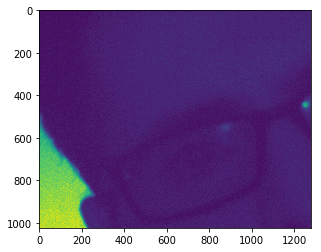

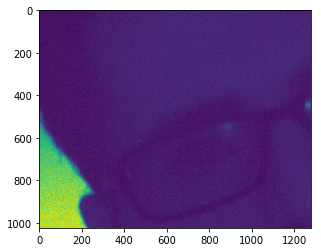

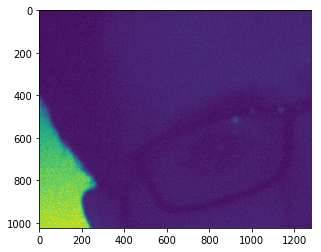

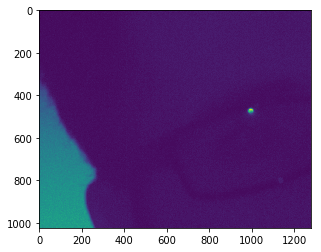

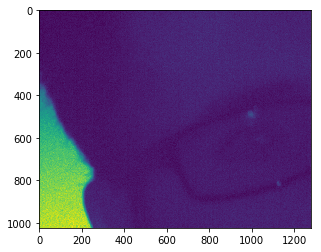

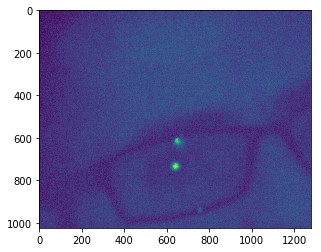

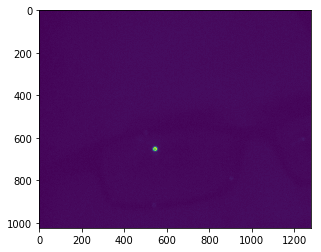

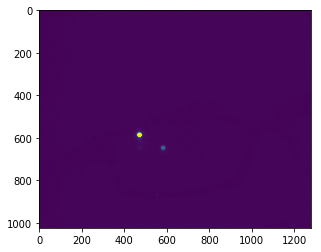

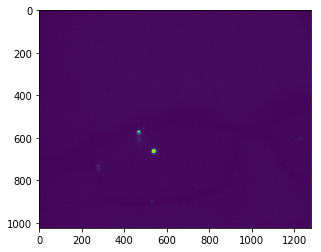

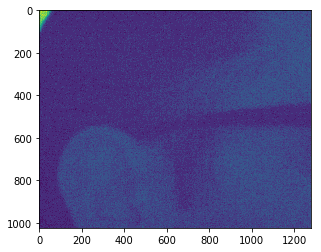

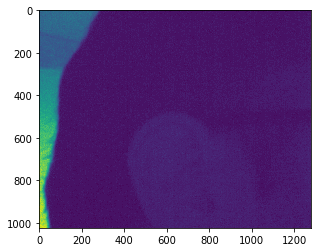

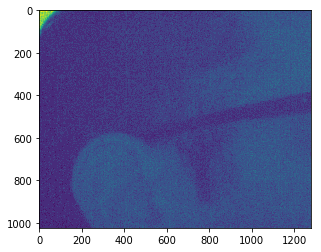

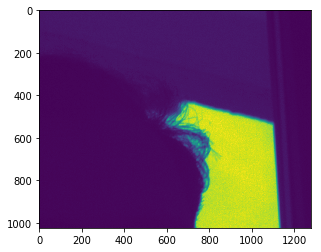

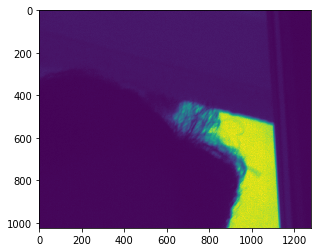

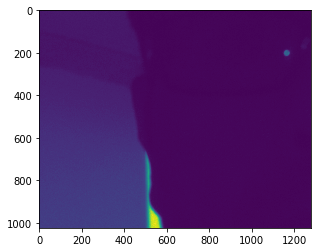

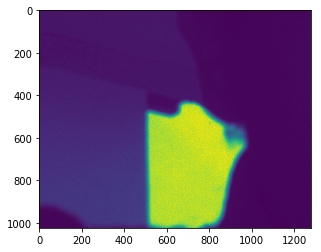

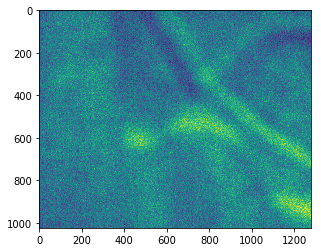

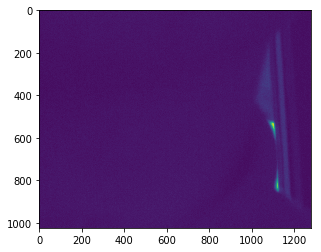

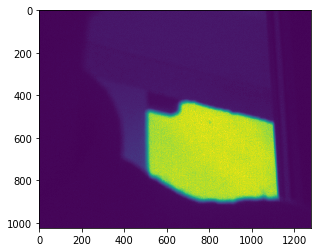

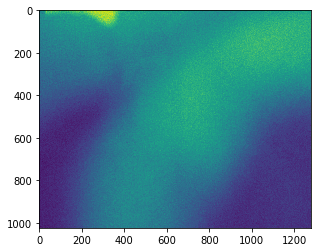

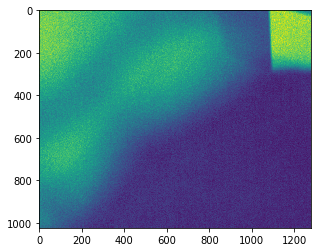

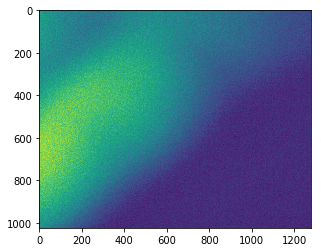

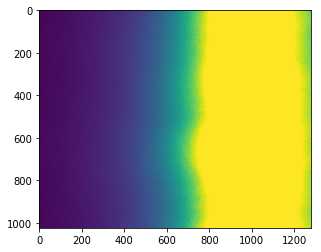

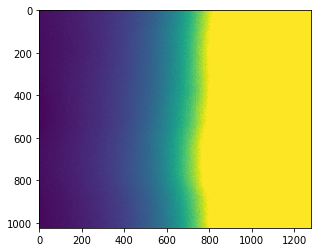

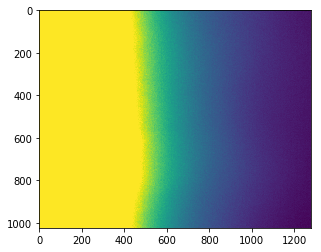

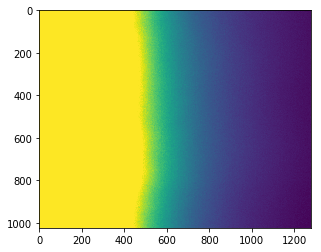

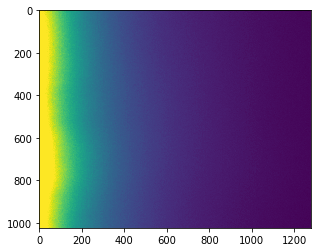

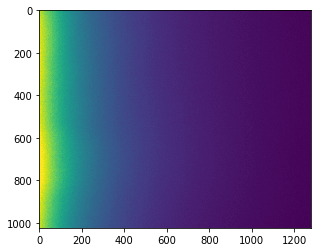

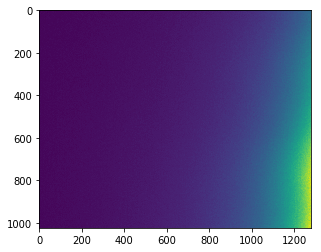

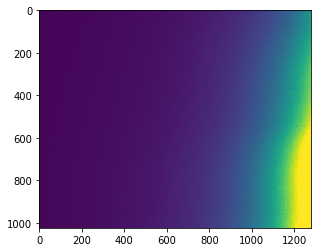

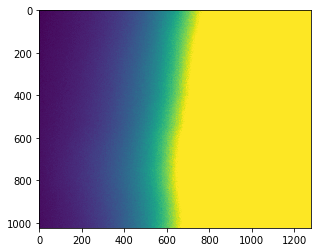

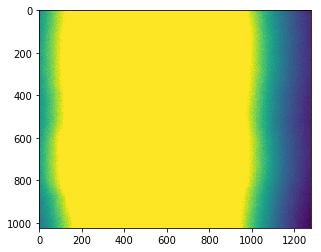

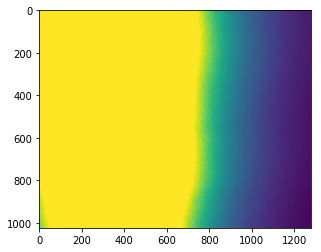

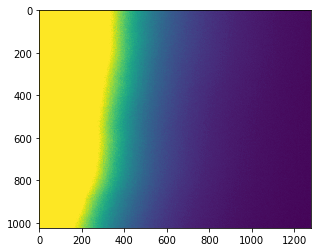

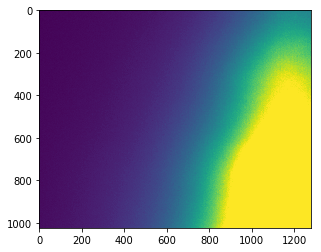

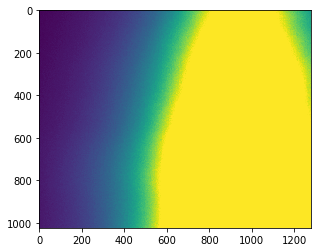

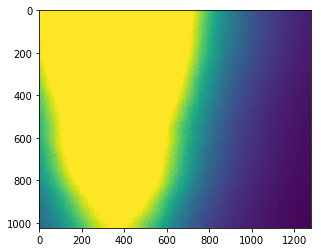

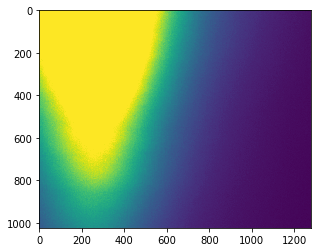

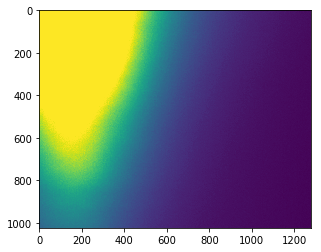

In [15]:
for i in range(1,56):
    img = single_trigger(cam,ser,i)
    plt.imshow(img)
    plt.show()

In [18]:
# all_off = [0xaa,0x05,0x00,0x00,0x00,int(hex(14),16),0x00]#,0x00]
# all_off.append(calculate_checksum(all_off))

# command_bytes = bytes(all_off)

# ser.write(command_bytes)
# time.sleep(1)

command = [0xaa,0x06,0x00,int(hex(10),16),int(hex(0),16),int(hex(100),16),int(hex(6),16)]
command.append(calculate_checksum(command))
command_bytes = bytes(command)
# print(command_bytes)
ser.write(command_bytes)
r = ser.read()
print(int.from_bytes(r, "big"))


6


In [42]:
# Test 1 -- led delay settings
all_off = [0xaa,0x03,0x00,0x02,0x64,0x00,0x00,0x00]
# all_off.append(calculate_checksum(all_off))

command_bytes = bytes(all_off)
ser.write(command_bytes)


8

In [43]:
# all_off = [0xaa,0x05,0x00,0x00,0x01int(hex(14),16),0x00]#,0x00]
# inter led min delay should be more than 0.125
# all_off.append(calculate_checksum(all_off))

# command_bytes = bytes(all_off)

# ser.write(command_bytes)

imgs = [np.zeros((1024, 1280))]*55

for i in range(1,56):
    command = [0xaa,0x06,0x00,int(hex(10),16),int(hex(0),16),int(hex(50),16),int(hex(i),16)]
    command.append(calculate_checksum(command))
    command_bytes = bytes(command)

    ser.write(command_bytes)
    #r = ser.read()
    #print(int.from_bytes(r, "big"))

    # imgs[i-1] = cam.get_image()
    time.sleep(0.125)
    

In [44]:
import matplotlib.pyplot as plt
plt.imshow(np.zeros((10,10)))
plt.show()

In [45]:
command = [0xaa,0x06,0x00,int(hex(10),16),int(hex(0),16),int(hex(100),16),int(hex(6),16)]
command.append(calculate_checksum(command))
command_bytes = bytes(command)
# print(command_bytes)
ser.write(command_bytes)
time.sleep(1)
r = ser.read()
print(r)

b'\x01'


In [36]:
all_off_(cam,ser,trigstate=0)
time.sleep(0.2)
imgs = []
for i in range(1,56):
    single_trigger(cam=cam,ser=ser,ledNum=i)
    #imgs.append()

time.sleep(0.2)
all_off_(cam,ser,trigstate=0)

KeyboardInterrupt: 

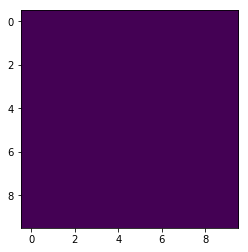

In [47]:
import matplotlib.pyplot as plt
plt.imshow(np.zeros((10,10)))
plt.show()

In [ ]:
for img in imgs:
    plt.figure(figsize=(10,10))
    plt.imshow(img,'gray')
    plt.show()

In [7]:
# tarama modundan önce bu çalıştırılmalı !!!!!!!!!!!!!!
def set_delays(ser,delay=12):
    # led delay setting
    protokol= {'command to be sent':0xaa,
                'run auto burst':0x03,
                'N/A1':0x00,
                'trigger delay':int(hex(10),16),
                'led delay':int(hex(5),16),
                'N/A2':0x00,
                'N/A3':0x00,
                'checksum':0x00}

    command = [0xaa,0x03,0x00,int(hex(protokol['trigger delay']),16),int(hex(protokol['led delay']),16),0x00,0x00]
    command.append(calculate_checksum(command))
    command_bytes = bytes(command)
    print(command_bytes)
    ser.write(command_bytes)
    
set_delays(ser)

b'\xaa\x03\x00\n\x05\x00\x00\xa6'


In [8]:
def trigger(cam,ser):
    # önce set_delays(ser) yi çalıştır. Önemli
    # tarama modu
    # protokol= {'command to be sent':0xaa,
    #             'run auto burst':0x02,
    #             'N/A':0x00,
    #             'N/A':0x01,
    #             'led intensity':int(hex(100),16),
    #             'animation speed':int(hex(30),16),
    #             'animation number':0x00,
    #             'checksum':0x00}
    try:
        cam.device.stop_acquisition()
    except:
        pass
    cam.device.start_acquisition()
    command = [0xaa,0x02,0x00,0x01,int(hex(99), 16),int(hex(14),16),0x01]
    command.append(calculate_checksum(command))
    command_bytes = bytes(command)
    #all_off_(cam=cam,ser=ser,trigstate=0)
    time.sleep(0.05)
    ser.write(command_bytes)
    j=0
    imgs=[]
    leds = []
    while True:
        # all_off_(cam=cam,ser=ser,trigstate=1)
        try:
            r = int.from_bytes(ser.read(), "big")
            
            leds.append(r)# önce 
            # a = cam.get_image()
            imgs.append(cam.get_image())
            print(r)
            if r >= 55:return imgs,leds
        except Exception as e:
            print(e)
            break
    return imgs,leds

In [39]:

len(imgs)
del(imgs)

In [44]:
imgs,leds = trigger(cam,ser)

26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


In [9]:
def trigger2(ser):
    # önce set_delays(ser) yi çalıştır. Önemli
    # tarama modu
    # protokol= {'command to be sent':0xaa,
    #             'run auto burst':0x02,
    #             'N/A':0x00,
    #             'N/A':0x01,
    #             'led intensity':int(hex(100),16),
    #             'animation speed':int(hex(30),16),
    #             'animation number':0x00,
    #             'checksum':0x00}
    '''
    all_off = [0xaa,0x05,0x00,0x00,0x00,int(hex(14),16),0x01]#,0x00]
    all_off.append(calculate_checksum(all_off))

    command_bytes = bytes(all_off)
    
    # print('trigstate:',trigstate)
    ser.write(command_bytes)
    '''
    time.sleep(0.05)
    command = [0xaa,0x02,0x00,0x01,int(hex(99), 16),int(hex(14),16),0x01]
    #command = [0xaa,,,,,,,,,,,,,0x00,0x01,int(hex(99), 16),int(hex(14),16),0x01]
    command.append(calculate_checksum(command))
    command_bytes = bytes(command)
    
    ser.write(command_bytes)
    
    try:
        cam.device.stop_acquisition()
        time.sleep(0.05)
    except:
        pass 
    cam.device.start_acquisition()
    time.sleep(0.05)
    
    j=0
    imgs=[]
    leds = []
    time.sleep(0.05)
    while True:
        # all_off_(cam=cam,ser=ser,trigstate=1)
        try:
            r0 = ser.read()
            r = int.from_bytes(r0, "big")
            
            
            leds.append(r)# önce 
            imgs.append(cam.get_image())
            print(r)
            if r >= 55:return imgs,leds
        except Exception as e:
            print(e)
            break
    return imgs,leds
try:
    del imgs,leds
except:
    pass
imgs,leds =trigger2(ser)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


In [16]:
import cv2
p='test_images'
for i,img in enumerate(imgs):
    cv2.imwrite(f'{p}/{i}.png',img)
#[cv2.imwrite(f'{p}/{i}.png',img) for i,img in enumerate(imgs)]

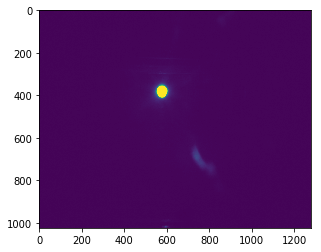

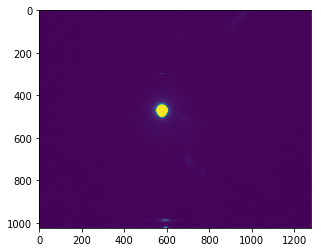

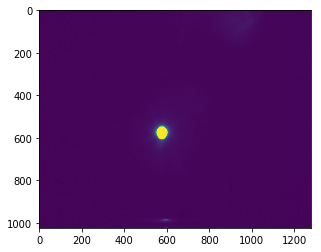

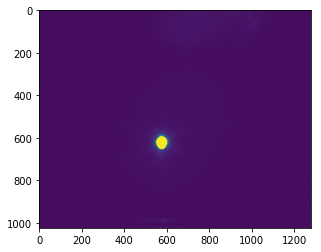

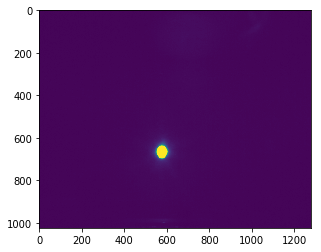

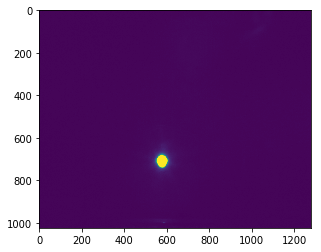

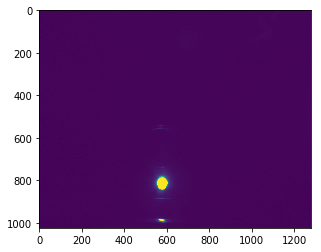

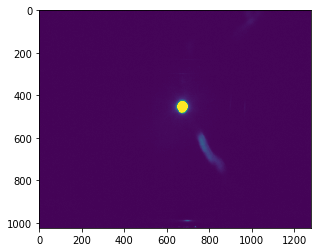

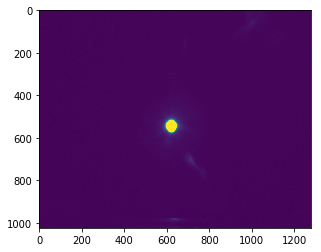

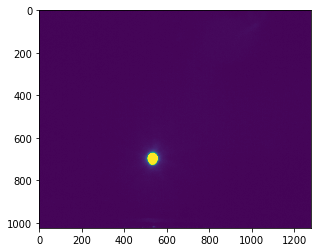

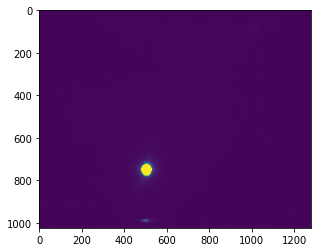

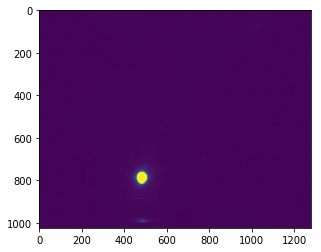

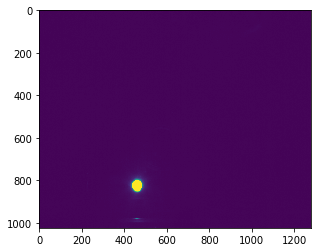

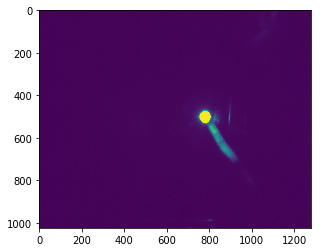

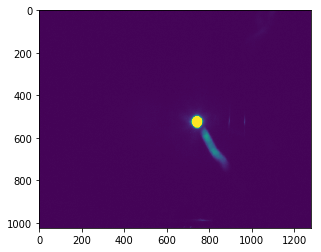

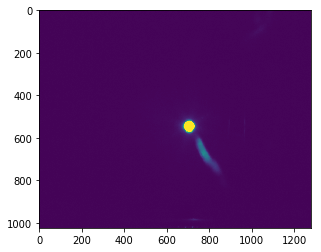

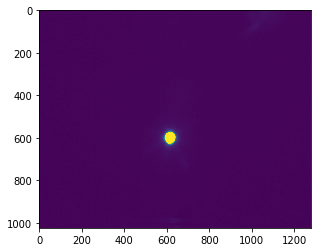

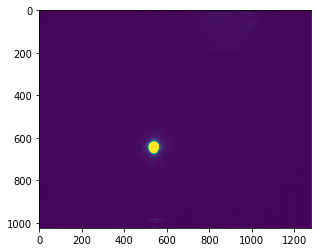

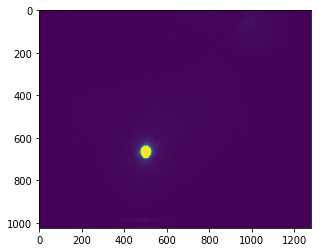

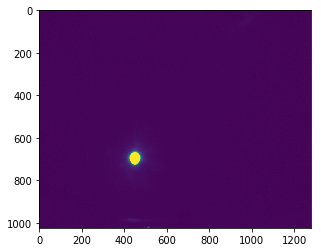

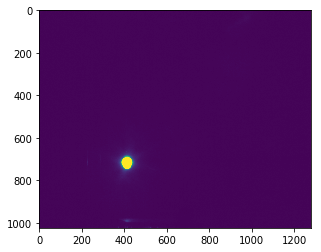

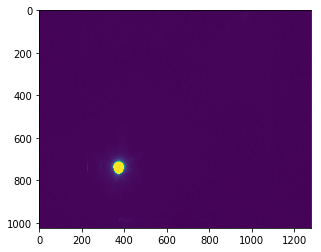

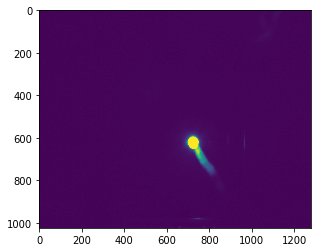

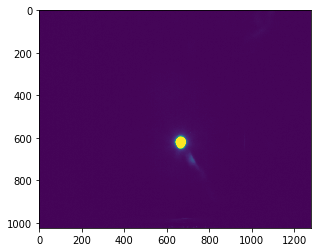

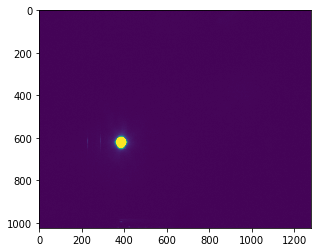

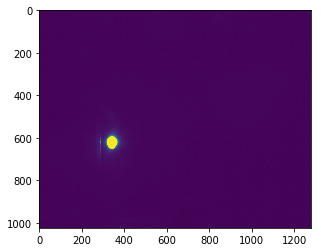

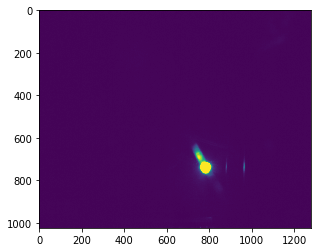

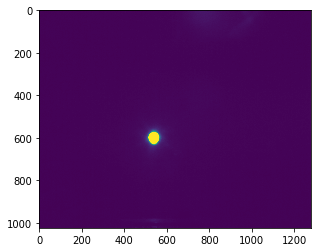

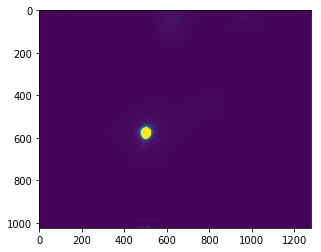

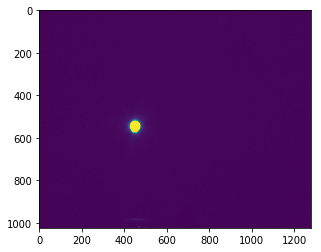

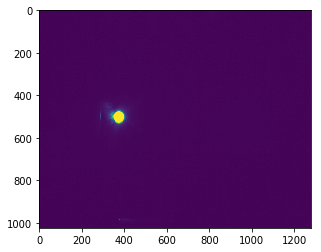

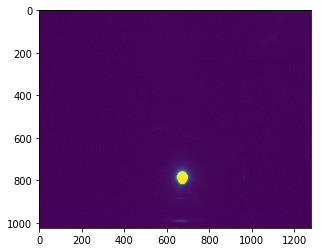

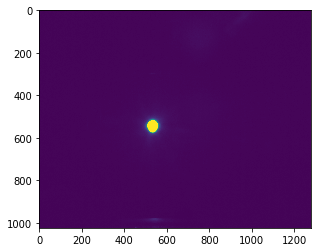

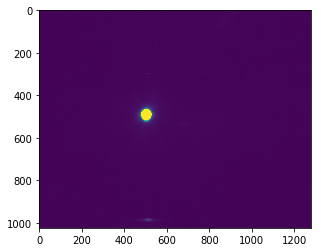

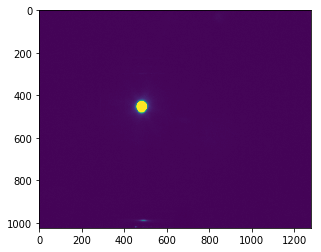

In [10]:
import matplotlib.pyplot as plt
for img in imgs:
    plt.imshow(img)
    plt.show()

In [ ]:
def turn_on(ser,ledNum):
    # IR Led Test
    protokol= {'command to be sent':0xaa,
                'run single burst':0x04,
                'N/A':0x00,
                'N/A':0x00,
                'on/off':0x01,
                'led intensity':int(hex(100),16),
                'IR led No':int(hex(1),16),
                'checksum':0x00}

    command = [0xaa,0x04,0x00,0x00,0x01,int(hex(100),16),int(hex(ledNum),16)]
    command.append(calculate_checksum(command))
    command_bytes = bytes(command)
    # print(command_bytes)
    ser.write(command_bytes)
    
def turn_off(ser,ledNum):
    command = [0xaa,0x04,0x00,0x00,0x00,int(hex(100),16),int(hex(ledNum),16)]
    command.append(calculate_checksum(command))
    command_bytes = bytes(command)
    # print(command_bytes)
    ser.write(command_bytes)

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.imshow(np.zeros((10,10)))
img = all_off(cam=cam,ser=ser,trigstate=1)
plt.imshow(img)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
all_off = [0xaa,0x05,0x00,0x00,0x01,int(hex(14),16),0x01]#,0x00]
all_off.append(calculate_checksum(all_off))

command_bytes = bytes(all_off)
ser.write(command_bytes)

In [ ]:
command = [0xaa,0x04,0x00,0x00,0x01,int(hex(100),16),int(hex(1),16)]
command.append(calculate_checksum(command))
command_bytes = bytes(command)
time.sleep(0.8)
for i in range(1,55):
    all_off = [0xaa,0x05,0x00,0x00,0x01,int(hex(14),16),0x01]#,0x00]
    all_off.append(calculate_checksum(all_off))

    command_bytes = bytes(all_off)
    ser.write(command_bytes)
    # print(command_bytes)
    time.sleep(0.8)
    ser.write(command_bytes)
    command = [0xaa,0x04,0x00,0x00,0x01,int(hex(100),16),int(hex(i+1),16)]
    command.append(calculate_checksum(command))
    command_bytes = bytes(command)
    # print(command_bytes)
    ser.write(command_bytes)
    time.sleep(0.8)
    
all_off = [0xaa,0x05,0x00,0x00,0x01,int(hex(14),16),0x01]#,0x00]
all_off.append(calculate_checksum(all_off))

command_bytes = bytes(all_off)
ser.write(command_bytes)

In [ ]:
img = all_off(cam=cam,ser=ser,trigstate=1)
time.sleep(1)
turn_on(ser,5)
fs = []
j = 0
while True:
    try:
        fs.append(cam.get_image())
    except KeyboardInterrupt:
        break
    j+=1
    if j>10:break
plt.imshow(fs[0])
plt.show()

In [ ]:
# led delay setting
protokol= {'command to be sent':0xaa,
            'run auto burst':0x03,
            'N/A':0x00,
            'trigger delay':int(hex(1),16),
            'led delay':int(hex(1),16),
            'N/A':0x00,
            'N/A':0x00,
            'checksum':0x00}

command = [0xaa,0x03,0x00,int(hex(3),16),int(hex(6), 16),0x00,0x00]
command.append(calculate_checksum(command))
command_bytes = bytes(command)
print(command_bytes)
ser.write(command_bytes)
# print(ser.read(8))

In [ ]:
command = [0xaa,0x02,0x00,0x01,int(hex(100), 16),int(hex(0),16),0x00]
command.append(calculate_checksum(command))
command_bytes = bytes(command)
print(command_bytes)
ser.write(command_bytes)


In [ ]:
imgs={}
img = all_off(cam=cam,ser=ser,trigstate=1)
time.sleep(1)
for ledNum in range(1,56):
    turn_on(ser,ledNum)
    time.sleep(0.2)
    imgs[ledNum]=cam.get_image()
    time.sleep(0.3)
    # time.sleep(0.8)
    # for i in range(5):
    #     turn_off(ser,ledNum)
    #     time.sleep(0.1)
    # time.sleep(0.8)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.zeros((10,10)))
plt.show()

In [ ]:
img = all_off(cam=cam,ser=ser,trigstate=0)


In [ ]:
ser.readlines()


In [ ]:
command = [0xaa,0x02,0x00,0x01,int(hex(50), 16),int(hex(0),16),0x00]
command.append(calculate_checksum(command))
command_bytes = bytes(command)
all_off(cam=cam,ser=ser,trigstate=1)
ser.write(command_bytes)
j=0
imgs=[]
leds = []
while True:
    try:
        leds.append(int.from_bytes(ser.read(), "big"))
        imgs.append(cam.get_image())
    except Exception as e:
        print(e)
        break

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
shp = list(imgs[0].shape)
shp.append(3)
tmp = np.zeros(shp)
tmp[:,:,0]=imgs[0]
tmp[:,:,1]=imgs[1]
tmp[:,:,2]=imgs[2]
plt.imshow(tmp)
plt.show()

In [ ]:
for img,led in zip(imgs,leds):
    print(led)
    plt.imshow(img)
    plt.show()

In [ ]:
# del(imgs)
# all_off(cam=cam,ser=ser,trigstate=0)
img = all_off(cam=cam,ser=ser,trigstate=1)
# print(img)
i = 0
j = 0
while True:
    img = illuminate(cam=cam,ser=ser)
    # clear_output(wait=True)
    # plt.imshow(img)
    # plt.show()
    i+=1
    if i>10:
        i=0
        _ = all_off(cam=cam,ser=ser,trigstate=1)
        imgs = trigger(cam=cam,ser=ser)
        break
        

In [ ]:
for led,img in imgs.items():
    print('-----',led)
    plt.imshow(img)
    plt.show()
    

In [ ]:
import matplotlib.pyplot as plt
for img in imgs:
    plt.imshow(img,'gray')
    plt.show()

In [ ]:
len(imgs)

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(imgs[0])
plt.show()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fs = []
j = 0
img = all_off(cam=cam,ser=ser,trigstate=1)
time.sleep(3)
turn_on(ser,40)
while True:
    try:
        fs.append(cam.get_image())
    except KeyboardInterrupt:
        break
    j+=1
    if j>100:break
plt.imshow(fs[0])
plt.show()

In [ ]:
plt.imshow(fs[14])
plt.show()

In [ ]:
self.device.close()

In [ ]:
# IR Led Test
protokol= {'command to be sent':0xaa,
            'run single burst':0x04,
            'N/A':0x00,
            'N/A':0x00,
            'on/off':0x01,
            'led intensity':int(hex(100),16),
            'IR led No':int(hex(1),16),
            'checksum':0x00}
i = 11
command = [0xaa,0x04,0x00,0x00,0x00,int(hex(80),16),int(hex(i-1),16)]
command.append(calculate_checksum(command))
command_bytes = bytes(command)
print(command_bytes)
ser.write(command_bytes)
time.sleep(0.5)
command = [0xaa,0x04,0x00,0x00,0x01,int(hex(80),16),int(hex(i),16)]
command.append(calculate_checksum(command))
command_bytes = bytes(command)
print(command_bytes)
ser.write(command_bytes)

# print(ser.read(8))
# R	0xA5	0x04	0x00	Önemli değil			IR Led No
ser.write([0x05,0x04,0x00,0x00,0x01,0x00])
# print(ser.read())


## check sum olmadan: 

    #  Tümünü kapatma modu:
    
        - Animasiyon kapatma çalıştı  (ok)
        - all off çalıştı (ok)
        - animasiyon hız ayarı çalıştı    (ok)
        - trigger on/off all-ff modunda çalıştı   (ok)

    # Aydınlatma modu:
        - Parlaklık değişiyor. (ok)
        - animasiyon hızı ayarı çalışıyor   (ok)
        - animasiyon seçimi çalışıyor    (ok)
        - geri dönüş okuma tamam  (ok)
        
    
    # tarama modu:
        
        - led parlaklık ayarı çalışmadı **
        - animasiyon hız ayarı çalışmadı **
        - animasiyon seçimi çalıştı (ok)
        - geri dönüş okuma tamam  (ok)
        
    # led delay setting:

        - Bunu uygulayamadım **

    # IR led Test:

        - Parlaklık değişiyor. (ok)
        - on/off çalışıyor (ok)
        - led Num (ok)
        - - geri dönüş okuma çalışmadı**
        

In [ ]:
all_off = [0xaa,0x05,0x00,0x00,0x00,0x01,0x00,0x00]
AA 02 00 00 00 14 01 BD
command_bytes = bytes(all_off)
print(command_bytes)
ser.write(command_bytes)
time.sleep(0.1)


# i=1
# cmd = [0xaa,0x05,0x00,0x00,0x00,0x00,0x01]
# cmd.append(calculate_checksum(cmd))
# off = bytes(cmd)

# ser.write(off)


In [ ]:
time.sleep(0.09)
on = bytes([0xaa,0x04,0x00,0x00,0x01,int(hex(50), 16),int(hex(i+1), 16),0x00])

ser.write(on)
readcom = bytes([0xa5,0x01,0x00,0x00,0x00,int(hex(50), 16),int(hex(i), 16),0x00])
r = ser.read(8)
print(r)

In [ ]:
for i in range(56):
    on = bytes([0xaa,0x04,0x00,0x00,0x01,int(hex(50), 16),int(hex(i+1), 16),0x00])
    ser.write(on)
    # read = bytes([0xa5,0x04,0x00,0x00,0x00,0x00,int(hex(i+1), 16),0x00])

    # print('on: ',ser.read())
    # a = ser.read(8)
    # print('yaktıktan sonra: ',a)
    print('waiting ...')
    time.sleep(delay)
    # print('read komutu gönder')
    # ser.write(read)
    # print('r: ',ser.read(8))
    off = bytes([0xaa,0x04,0x00,0x00,0x00,int(hex(50), 16),int(hex(i+1), 16),0x00])
    ser.write(off)
    time.sleep(delay/2)

In [ ]:
ser.close()


In [ ]:
# print(ser.read())
# illuminations = [il for il in range(25,101,10)]
# ons = [bytes([0xaa,0x04,0x00,0x00,0x01,int(hex(i), 16),0x06,0x00]) for i in illuminations]
# reads = [bytes([0xa5,0x01,0x00,0x00,0x01,int(hex(i), 16),0x06,0x00]) for i in illuminations]

# # Aydınlatma modu testi
# i=0
# delay=0.06
# print('led on ...')
for i in range(56):
    on = bytes([0xaa,0x04,0x00,0x00,0x01,int(hex(50), 16),int(hex(i+1), 16),0x00])
    ser.write(on)
    # read = bytes([0xa5,0x04,0x00,0x00,0x00,0x00,int(hex(i+1), 16),0x00])

    # print('on: ',ser.read())
    # a = ser.read(8)
    # print('yaktıktan sonra: ',a)
    print('waiting ...')
    time.sleep(delay)
    # print('read komutu gönder')
    # ser.write(read)
    # print('r: ',ser.read(8))
    off = bytes([0xaa,0x04,0x00,0x00,0x00,int(hex(50), 16),int(hex(i+1), 16),0x00])
    ser.write(off)
    time.sleep(delay/2)
# # b = ser.read(8)
# # print('söndürdükten sonra: ', b)
# # print('reading code writing ...')





# while True:
#     r = ser.read()#.decode('ascii')
#     # integers = [int.from_bytes(bs, byteorder='big') for bs in byte_strings]
#     print(r)
#     if r==b'U':
#         break
#     i+=1
# print('response: ',ser.read(8))

# read = [0xa5, 0x05, 0x00, 0x00, 0x00, 0x00, 0x00]
# read.append(calculate_checksum(read))
# print(read)
# ser.write(read)
# print('writing done ...')
# output = ser.read()
# print('output: ',output)

# ser.write(command_bytes)
# ser.write(reads[0])
# output = ser.read()

# print(output)

# for i in range(1,56):
#     print(hex(i))
#     on = [0xaa,0x04,0x00,0x00,0x01,0x15,int(hex(i), 16),0x00]

#     command_bytes = bytes(on)
#     print(command_bytes)
#     ser.write(command_bytes)
#     time.sleep(1)
#     off = [0xaa,0x05,0x00,0x00,0x00,0x01,0x00,0x00]
#     # off = [0xaa,0x04,0x00,0x00,0x00,0x15,int(hex(i), 16),0x00]
#     command_bytes2 = bytes(off)
#     print(command_bytes2)
#     ser.write(command_bytes2)


# trig gecikmesi testi
# led gecikmesi testi